# Timeseries forecasting
Very simple example of trying to forecast a timeseries of electrical consuption at a plant. Data is from: https://github.com/zhouhaoyi/ETDataset/tree/main

Datasets are from two powerplants.
- Datasets m1, m2 are taken at minute level
- Datasets h1, h2 are taken at hour level

Description of the content: Each data point consists of 8 features, including the date of the point, the predictive value "oil temperature", and 6 different types of external power load features.

The target is the oil temperature (OT).

In [1]:
import pandas as pd 

df = pd.read_csv("../data/ETT-small/ETTh1.csv")
print(f"{df.columns}, {df.size}")

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object'), 139360


/tmp/ipykernel_1551/2436512062.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
target = df["OT"]
target.shape

(17420,)

In [3]:
import matplotlib.pyplot as plt

def visualize_ts(fig_name, ts, ts_name):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(ts, label=ts_name)

    # Adding a plot title and customizing its font size
    plt.title(fig_name)

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

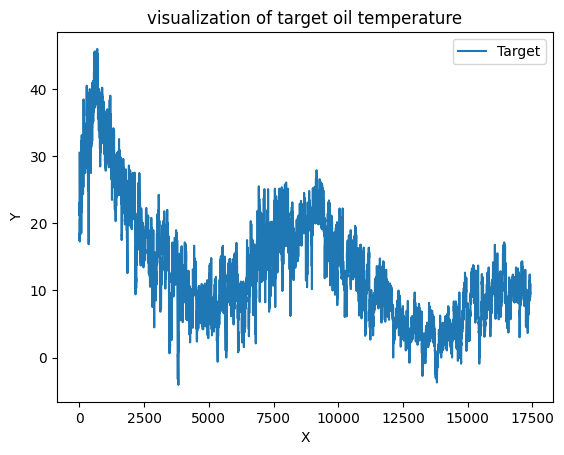

In [4]:
visualize_ts("visualization of target oil temperature", target, "Target")

# Model building
A very simple LSTM model

In [5]:
import torch
import torch.nn as nn

class LstmForecaster(nn.Module):
    lstm_layer: nn.LSTM
    output_linear_layer: nn.Linear

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_linear_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        #Pass through LSTM (L,N,Hin​)
        x, _ = self.lstm_layer(x)

        #Return linear layer prediction for next value based on the last very last hidden output of every batched input
        x = self.output_linear_layer(x[:, -1, :])
        return x

# Data preparation
Prepare data: Prepare trajectories for the forecasting task and put then in pytorch dataloards

Shape of X data: torch.Size([17270, 150, 1])
Shape of y data: torch.Size([17270, 1])
Shape of train dataset: torch.Size([13816, 150, 1])
Shape of test dataset: torch.Size([3454, 150, 1])


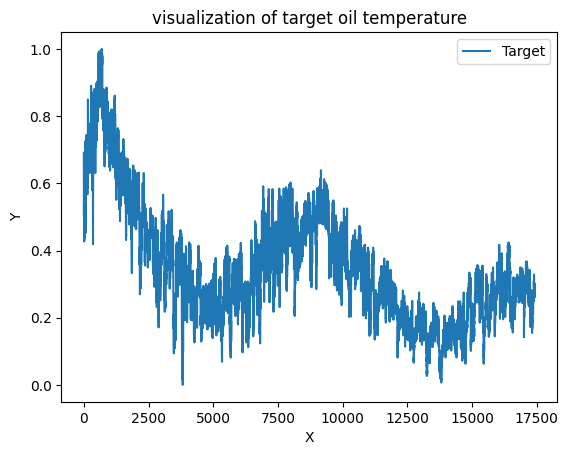

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Task Constants
LOOKBACK= 150
FORECAST_SIZE = 50

target_np = target.to_numpy()

#Apply scalign to the whole dataset before creating the trajectories
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target_np.reshape(-1, 1))

#Create trajectories
X, y = [], []
for i in range(0, len(target_scaled) - LOOKBACK):
    X.append(target_np[i:i+LOOKBACK])
    y.append(target_np[i+LOOKBACK])

X, y = torch.FloatTensor(np.asarray(X)), torch.FloatTensor(np.asarray(y))
X, y = X.unsqueeze(-1), y.unsqueeze(-1)

print(f"Shape of X data: {X.shape}")
print(f"Shape of y data: {y.shape}")

test_size = 0.2  # Adjust the test set size as needed
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Shape of train dataset: {X_train.shape}")
print(f"Shape of test dataset: {X_test.shape}")

class SimpleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 32
shuffle = False

train_dataset = SimpleDataset(X_train, Y_train)
test_dataset = SimpleDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

visualize_ts("visualization of target oil temperature", target_scaled, "Target")

# Prepare visualization function of predicted / actual 

In [10]:
import matplotlib.pyplot as plt

def plot_forecast(predicted_ts, expected_ts, lookback_size):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(predicted_ts, label="Predicted values", color="g")
    plt.plot(expected_ts, label="Expected values", color="b")

    # Adding a plot title and customizing its font size
    plt.title("Forecasting outcomes")
    plt.axvline(lookback_size-1, 0, 1, linestyle="dashed")

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

# Train model

In [12]:
import numpy as np

# Model-related constants
INPUT_SIZE = 1
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = LstmForecaster(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

#Loop-related
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch}...", end="")

  batch_train_losses = []
  for X_train, y_train in train_dataloader:
    y_pred = (model(X_train))

    loss = loss_fn(y_pred, y_train)
    batch_train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  epoch_training_loss = np.mean(batch_train_losses)
  train_losses.append(epoch_training_loss)
  print(f"Mean training loss: {epoch_training_loss}")

  with torch.no_grad():
    test_batch_losses = []

    for X_test, y_test in test_dataloader:
      test_pred = model(X_test)

      loss = loss_fn(test_pred, y_test)
      test_batch_losses.append(loss.item())
    
    epoch_test_loss = np.mean(test_batch_losses)
    test_losses.append(epoch_test_loss)
    print(f'Test Loss: {epoch_test_loss:.4f}')


Epoch 0...Mean training loss: 78.30826910833518
Test Loss: 20.2290
Epoch 1...Mean training loss: 11.923089909125808
Test Loss: 6.8215
Epoch 2...Mean training loss: 4.605076095641211
Test Loss: 2.9738
Epoch 3...Mean training loss: 2.300201736666538
Test Loss: 1.6725
Epoch 4...Mean training loss: 1.4960645584872476
Test Loss: 1.2023
Epoch 5...Mean training loss: 1.1704303671571392
Test Loss: 1.0213
Epoch 6...Mean training loss: 1.0145715827260304
Test Loss: 0.9245
Epoch 7...Mean training loss: 0.9226786742607752
Test Loss: 0.8340
Epoch 8...Mean training loss: 0.8829524008971121
Test Loss: 0.7907
Epoch 9...Mean training loss: 0.8659463968403913
Test Loss: 0.7885
Epoch 10...Mean training loss: 0.8580031943404012
Test Loss: 0.7925
Epoch 11...Mean training loss: 0.8284641237308582
Test Loss: 0.8047
Epoch 12...Mean training loss: 0.8327572152915376
Test Loss: 0.8334
Epoch 13...Mean training loss: 0.8144576547805358
Test Loss: 0.7811
Epoch 14...Mean training loss: 0.812739988685482
Test Loss: 

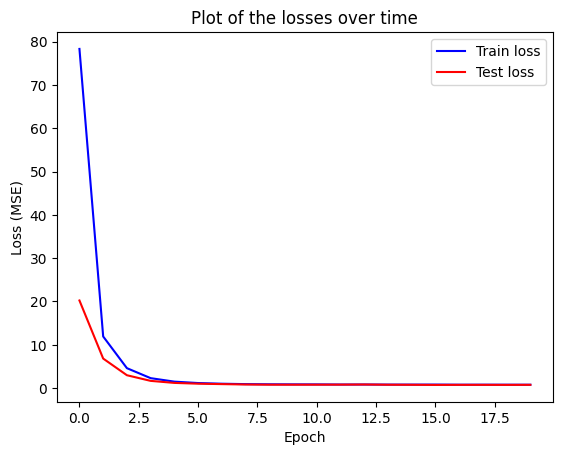

In [13]:
def plot_losses(train_loss, test_loss):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(train_loss, label="Train loss", color="b")
    plt.plot(test_loss, label="Test loss", color="r")

    # Adding a plot title and customizing its font size
    plt.title("Plot of the losses over time")

    # Adding axis labels and customizing their font size
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    plt.legend()
    plt.show()

plot_losses(train_losses, test_losses)

#Output some predictions

Sampling 300 data from ID 8178
Generating forecast of length 50


/tmp/ipykernel_1551/744020143.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data).float()


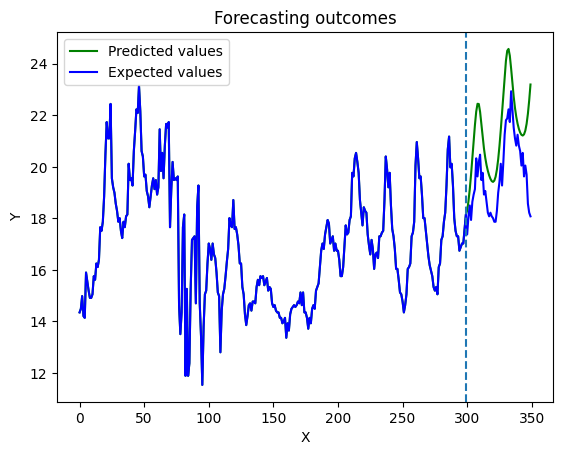

In [23]:
LOOKBACK = 300
FORECAST_SIZE = 50

def make_prediction(model, X, lookback, forecast_lengt):
    #Prepare a random dataset sample

    with torch.no_grad():
        predictions = []
        input_data = X.reshape(1, lookback, 1)
        
        for _ in range(forecast_lengt):
            input_tensor = torch.tensor(input_data).float()
            pred = model(input_tensor)
            predictions.append(pred[0][0])
            input_data = np.append(input_data[:, 1:, :], pred).reshape(1, lookback, 1)

        return predictions

# target_np is the timeseries as a simple numpy ndarray
idx = np.random.randint(0, len(target_np) - (LOOKBACK + FORECAST_SIZE) - 1)
print(f"Sampling {LOOKBACK} data from ID {idx}")
lookback = torch.tensor(target_np[idx:idx+LOOKBACK]).unsqueeze(-1)
groundtruth_forecast = target_np[idx+LOOKBACK : idx+LOOKBACK+FORECAST_SIZE]

print(f"Generating forecast of length {FORECAST_SIZE}")
y_predicted = make_prediction(model, lookback, LOOKBACK, FORECAST_SIZE)


plot_forecast(lookback.reshape(LOOKBACK).tolist() + y_predicted, lookback.reshape(LOOKBACK).tolist() + groundtruth_forecast.tolist(), LOOKBACK)